In [19]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
# del X_train,X_test


7500
7500
2500
2500


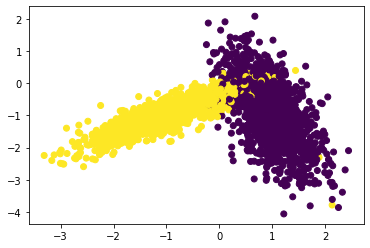

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [20]:
def RandomSearchCV(x_train, y_train, classifier, param_range, folds):
  params = list(random.sample(range(param_range[0],param_range[1]),10))
  #print(params)
  group_lst = []
  
  rem = len(x_train) % folds
  #print(rem)
  q = int(len(x_train)/folds)
  if rem == 0:
    for fold_value in range(1, folds+1):
      group_lst.append(list(x_train[q*(fold_value-1) : q*fold_value]))
    
  else:
    for fold_value in range(1, folds+1):
      group_lst.append(list(x_train[q*(fold_value-1) : q*fold_value]))
    
    for value in range(1, rem+1):
      lst = group_lst[folds-1]
      lst.append(x_train[len(x_train)-rem + value - 1])

  params = sorted(params)
  #print('x_train data in array format \n', group_lst, '\n')
  #print(len(group_lst))
  
  outer_lst = []
  for element in tqdm(group_lst):
    sub_lst = []
    for sub_ele in element:
      sub_lst.append(list(sub_ele))
  
    outer_lst.append(sub_lst)

  #print('x_train data in list format \n',outer_lst, '\n')
  #print(len(outer_lst))
  
  trainscores = []
  testscores = []
  for k in tqdm(params):
    #print("***********************************************\n k=",k)
    trainscores_fold = []
    testscores_fold = []
    
    for fold in list(enumerate(outer_lst)):
      x_train_train = []
      y_train_train = []
      y_train_test = []
      #print("fold number=", fold[0], '\n')
      x_train_test = outer_lst[fold[0]]
      #print('x_train_test data \n',x_train_test )
      #print(len(x_train_test))
      
      for ele in list(enumerate(outer_lst)):
        #print(list(enumerate(outer_lst)))
        
        if ele[0] != fold[0]:
          for tup in ele[1]:
            x_train_train.append(tup)

      #print('\n x_train_train data \n',x_train_train)
      #print(len(x_train_train))
      for ele in x_train_test:
        a = set(ele)
        for elem in enumerate(x_train):
          b = set(elem[1].tolist())
          if a == b:
            y_train_test.append(y_train[elem[0]])
          
      for ele in x_train_train:
        a = set(ele)
        for elem in enumerate(x_train):
          b = set(elem[1].tolist())
          if a == b:
            y_train_train.append(y_train[elem[0]])

      #print('\n y_train_test data \n',y_train_test)
      #print(len(y_train_test))
      #print('\n y_train_train data \n',y_train_train)
      #print(len(y_train_train))
      
      classifier.n_neighbors = k
      X = np.array(x_train_train)
      Y = np.array(y_train_train)
      classifier.fit(X, Y)

      y_train_predicted = classifier.predict(np.array(x_train_train))
      y_test_predicted = classifier.predict(np.array(x_train_test))
      
      trainscores_fold.append(accuracy_score(np.array(y_train_train), np.array(y_train_predicted)))
      testscores_fold.append(accuracy_score(np.array(y_train_test), np.array(y_test_predicted)))

    trainscores.append(np.mean(np.array(trainscores_fold)))
    testscores.append(np.mean(np.array(testscores_fold)))  

  return trainscores,testscores


100%|██████████| 8/8 [22:42<00:00, 170.36s/it]


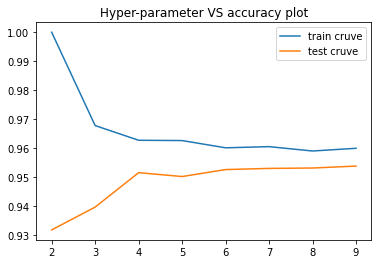

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

param_range = (1,20)
params = list(random.sample(range(param_range[0],param_range[1]),10))
params = sorted(params)
folds = 5

trainscores,testscores = RandomSearchCV(X_train,y_train,KNeighborsClassifier() , param_range, folds)
plt.plot(params, trainscores, label='train cruve')
plt.plot(params, testscores,  label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

In [23]:
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

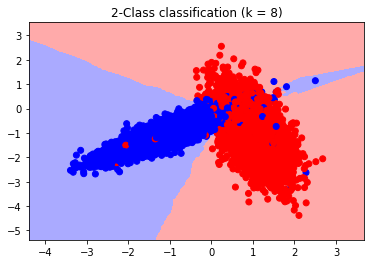

In [25]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 8)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)